<a href="https://colab.research.google.com/github/Laura-VFA/DataMining-21-22/blob/main/DM_Entrega3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Iago García Suárez  
- David González Bermúdez  
- Sergio Martínez Cid  
- Laura Villa Fernández-Arroyo

# Minería de datos
# Aplicación de modelo de minería de datos

## 1. Carga de datos

In [1]:
import json
import itertools
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import widgets
from sklearn import metrics, ensemble
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, train_test_split

In [2]:
!rm *.*

!wget https://raw.githubusercontent.com/Laura-VFA/DataMining-21-22/main/Datasets/agroanalisis_recolec.csv

!wget https://raw.githubusercontent.com/Laura-VFA/DataMining-21-22/main/Dicts/product_origen_inference.json
!wget https://raw.githubusercontent.com/Laura-VFA/DataMining-21-22/main/Dicts/available_products.json


--2022-01-19 17:25:13--  https://raw.githubusercontent.com/Laura-VFA/DataMining-21-22/main/Datasets/agroanalisis_recolec.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2241493 (2.1M) [text/plain]
Saving to: ‘agroanalisis_recolec.csv’

agroanalisis_recole 100%[===================>]   2.14M  --.-KB/s    in 0.05s   

2022-01-19 17:25:14 (46.2 MB/s) - ‘agroanalisis_recolec.csv’ saved [2241493/2241493]

--2022-01-19 17:25:14--  https://raw.githubusercontent.com/Laura-VFA/DataMining-21-22/main/Dicts/product_origen_inference.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP requ

In [3]:
agroanalisis = pd.read_csv('agroanalisis_recolec.csv', sep=';')
agroanalisis.drop(axis=1, labels=['Unnamed: 0'], inplace=True)
agroanalisis.head()

,product,origen,YEAR,MONTH,price_mean,Volumen,temperatura,Precipitacion_group,Min siem-recol,Max siem-recol,Temperatura min req,Temperatura max req,Temperatura min opt,Temperatura max opt,Dias entre riego zona seca,Dias entre riego zona húmeda,distancia_mes_inicio_siem,distancia_mes_fin_siem
0,ACELGA,Andalucia,2018,1,0.750238,46516.0,10.26,0.0,3,3,6.0,33.0,15.0,25.0,4,10,-8.0,-10.0
1,ACELGA,Andalucia,2018,1,0.750238,46516.0,10.26,0.0,3,3,6.0,33.0,15.0,25.0,4,10,-2.0,-4.0
2,ACELGA,Andalucia,2018,2,0.734375,37237.0,9.68,0.0,3,3,6.0,33.0,15.0,25.0,4,10,-7.0,-9.0
3,ACELGA,Andalucia,2018,2,0.734375,37237.0,9.68,0.0,3,3,6.0,33.0,15.0,25.0,4,10,-1.0,-3.0
4,ACELGA,Andalucia,2018,3,0.672059,78318.0,11.90,2.0,3,3,6.0,33.0,15.0,25.0,4,10,-6.0,-8.0


## 2. Transformación

Se añaden varias columnas con los valores relacionados al **precio, volumen y mes** en el cual se llevaría a cabo la recolección del cultivo. En el caso de que hubiera varias posibilidades, permanecería solo el cultivo cuyo precio sea más elevado. Esta operación puede resultar en nulos para algunos casos donde el cultivo no está en su periodo de siembra. Además, otros valores que no son de interés son aquellos que representan el **producto inexistente**, como es el caso de los registros con *Volumen = 0*. Para mantener una tarjeta de datos lo más limpia posible y sin ruido, se han **eliminado esos registros**.

In [4]:
for index1 in agroanalisis.index:
  if agroanalisis.at[index1, 'distancia_mes_inicio_siem'] >= 0 and agroanalisis.at[index1,'distancia_mes_fin_siem'] <= 0:
    interval = range(agroanalisis.at[index1,'Min siem-recol'],agroanalisis.at[index1,'Max siem-recol']+1)
    prices = []
    for year, month in map(lambda delta: (agroanalisis.at[index1,'YEAR'] if agroanalisis.at[index1,'MONTH']+delta <=12 else agroanalisis.at[index1,'YEAR']+1, (agroanalisis.at[index1,'MONTH']+delta) % 12), interval):
      result = agroanalisis[(agroanalisis['product'] == agroanalisis.at[index1,'product']) & \
                   (agroanalisis['origen'] == agroanalisis.at[index1,'origen']) & \
                   (agroanalisis['YEAR'] == year) & (agroanalisis['MONTH'] == month)]
      for index2 in result.index:
          prices.append((result.at[index2,'price_mean'], result.at[index2,'Volumen'], result.at[index2,'MONTH'] ))
    if prices:
      agroanalisis.at[index1, 'price_max_recolec'], agroanalisis.at[index1, 'Volumen_max_recolec'], agroanalisis.at[index1, 'MONTH_max_recolec'] = max(prices)

In [5]:
agroanalisis.head()

,product,origen,YEAR,MONTH,price_mean,Volumen,temperatura,Precipitacion_group,Min siem-recol,Max siem-recol,Temperatura min req,Temperatura max req,Temperatura min opt,Temperatura max opt,Dias entre riego zona seca,Dias entre riego zona húmeda,distancia_mes_inicio_siem,distancia_mes_fin_siem,price_max_recolec,Volumen_max_recolec,MONTH_max_recolec
0,ACELGA,Andalucia,2018,1,0.750238,46516.0,10.26,0.0,3,3,6.0,33.0,15.0,25.0,4,10,-8.0,-10.0,NaN,NaN,NaN
1,ACELGA,Andalucia,2018,1,0.750238,46516.0,10.26,0.0,3,3,6.0,33.0,15.0,25.0,4,10,-2.0,-4.0,NaN,NaN,NaN
2,ACELGA,Andalucia,2018,2,0.734375,37237.0,9.68,0.0,3,3,6.0,33.0,15.0,25.0,4,10,-7.0,-9.0,NaN,NaN,NaN
3,ACELGA,Andalucia,2018,2,0.734375,37237.0,9.68,0.0,3,3,6.0,33.0,15.0,25.0,4,10,-1.0,-3.0,NaN,NaN,NaN
4,ACELGA,Andalucia,2018,3,0.672059,78318.0,11.90,2.0,3,3,6.0,33.0,15.0,25.0,4,10,-6.0,-8.0,NaN,NaN,NaN


In [6]:
agroanalisis.dropna(inplace=True)

Se comprueba si algún registro se repite para un producto, lugar y fecha, ya que podría haber **periodos solapados**.

In [7]:
agroanalisis.shape

(3822, 21)

In [8]:
agroanalisis.groupby(['product', 'origen','YEAR', 'MONTH'], as_index=False).count()

,product,origen,YEAR,MONTH,price_mean,Volumen,temperatura,Precipitacion_group,Min siem-recol,Max siem-recol,Temperatura min req,Temperatura max req,Temperatura min opt,Temperatura max opt,Dias entre riego zona seca,Dias entre riego zona húmeda,distancia_mes_inicio_siem,distancia_mes_fin_siem,price_max_recolec,Volumen_max_recolec,MONTH_max_recolec
0,ACELGA,Andalucia,2018,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,ACELGA,Andalucia,2018,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,ACELGA,Andalucia,2018,5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,ACELGA,Andalucia,2018,10,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,ACELGA,Andalucia,2018,11,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3817,ZANAHORIA,Valencia,2019,11,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3818,ZANAHORIA,Valencia,2020,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3819,ZANAHORIA,Valencia,2020,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3820,ZANAHORIA,Valencia,2020,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Como tras hacer la agrupación el número de filas es el mismo, podemos concluir que no hay solapamientos.

Para **relacionar la humedad de una zona con la necesidad de riego de cada cultivo** se ha llevado a cabo una **discretización manual**, por la cual se comprueban los valores que pueden tomar todos los cultivos y se agrupan en 3 grupos, de los cuales el 0 corresponde al grupo que menos necesidad hídrica tiene y el 2 al que más necesidad hídrica tiene.

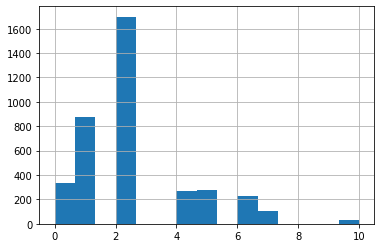

In [9]:
agroanalisis['Dias entre riego zona seca'].hist(bins=15)

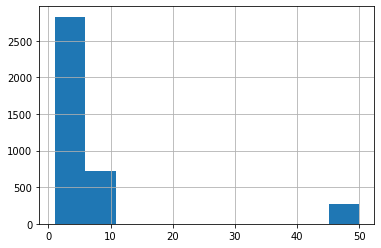

In [10]:
agroanalisis['Dias entre riego zona húmeda'].hist()

In [11]:
for index in agroanalisis.index:
  if agroanalisis.at[index, 'Dias entre riego zona seca'] < 2:
    val = 2
  elif agroanalisis.at[index, 'Dias entre riego zona seca'] < 4:
    val = 1
  else:
    val = 0
  agroanalisis.at[index, 'need_humidity_group'] = val

Con la necesidad de riego ya discretizada y el precio en el mes de recolección calculado, podemos **eliminar las columnas** correspondientes a los días entre riego para zonas secas y húmedas y a los meses de cultivo, ya que no volverán a ser necesarias (la columna *Dias entre riego zona húmeda* no es necesaria puesto que las necesidades de riego son bien descritas con la columna *Dias entre riego zona seca*, ya que muestra bien qué tiene que ser regado con más o menos frecuencia, que es lo que interesa).

In [12]:
agroanalisis.drop(axis=1, labels=['Dias entre riego zona seca', 'Dias entre riego zona húmeda', 'Min siem-recol', 'Max siem-recol'], inplace=True)

También se comprobará si hay registros cuyo volumen vendido en el mes máximo de la recolección sea 0, ya que puede ocurrir que no se vendiesen piezas de un producto en ese mes concreto. En tal caso deben eliminarse.  
Así, como ya se ha calculado el precio máximo de la recolección y su volumen, las columnas *price_mean* y *Volumen* quedan un poco obsoletas y pueden descartarse.

In [13]:
agroanalisis['Volumen_max_recolec'].describe()

count    3.822000e+03
mean     3.896903e+05
std      1.066783e+06
min      0.000000e+00
25%      1.144100e+04
50%      5.636800e+04
75%      2.354790e+05
max      1.452241e+07
Name: Volumen_max_recolec, dtype: float64

In [14]:
agroanalisis.drop(agroanalisis[agroanalisis['Volumen_max_recolec'] <= 0].index, inplace=True)
agroanalisis.drop(labels=['price_mean', 'Volumen'], axis=1, inplace=True)


## 3. Línea de trabajo 1: ¿Cuál es el cultivo más rentable a sembrar?

### 3.1 Construcción del campo objetivo

A continuación, se creará una columna/característica en el *Dataframe*, que se corresponderá con la columna objetivo.  
El objetivo es **etiquetar los 5 mejores cultivos** (con mejor se refiere a un cultivo con el precio de los más altos) por mes, comunidad y año de esa fila. Así, para una agrupación por mes, comunidad y año, solo 5 cultivos tendrán un valor 1 en la nueva columna *rentable*. 
Así, esta columna tomará valores 0 o 1, representando que es no rentable y rentable, respectivamente.

In [15]:
agroanalisis['rentable'] = 0 # Creación de nueva columna, todos los valores 0
agroanalisis.head()

,product,origen,YEAR,MONTH,temperatura,Precipitacion_group,Temperatura min req,Temperatura max req,Temperatura min opt,Temperatura max opt,distancia_mes_inicio_siem,distancia_mes_fin_siem,price_max_recolec,Volumen_max_recolec,MONTH_max_recolec,need_humidity_group,rentable
5,ACELGA,Andalucia,2018,3,11.90,2.0,6.0,33.0,15.0,25.0,0.0,-2.0,1.035714,58905.0,6.0,0.0,0
7,ACELGA,Andalucia,2018,4,14.84,1.0,6.0,33.0,15.0,25.0,1.0,-1.0,0.725000,16570.0,7.0,0.0,0
9,ACELGA,Andalucia,2018,5,17.50,0.0,6.0,33.0,15.0,25.0,2.0,0.0,0.529167,35470.0,8.0,0.0,0
18,ACELGA,Andalucia,2018,10,18.05,1.0,6.0,33.0,15.0,25.0,1.0,-1.0,0.880000,61704.0,1.0,0.0,0
20,ACELGA,Andalucia,2018,11,13.19,1.0,6.0,33.0,15.0,25.0,2.0,0.0,0.682381,106154.0,2.0,0.0,0


A continuación, se irá iterando por filas teniendo en cuenta las posibles variaciones de origen, año y mes. Estas se ordenarán por *price_max_recolec* (de mayor a menor), y se tomarán las 5 primeras filas, correspondientes a los 5 cultivos más rentables. En esas filas se pondrá un valor 1 en la nueva característica *rentable*.

In [16]:
with warnings.catch_warnings():
  warnings.filterwarnings('ignore')
  for origen, year, month in itertools.product(agroanalisis['origen'].unique(), agroanalisis['YEAR'].unique(), agroanalisis['MONTH'].unique()):
    result = agroanalisis[(agroanalisis['origen'] == origen) & \
                    (agroanalisis['YEAR'] == year) & (agroanalisis['MONTH'] == month)]
    if len(result) > 0:
      result.sort_values('price_max_recolec', axis=0, ascending=False, inplace=True)
      agroanalisis.loc[(agroanalisis['origen'] == origen) & \
                      (agroanalisis['YEAR'] == year) & \
                      (agroanalisis['MONTH'] == month) & 
                      (agroanalisis['price_max_recolec'] >= list(result['price_max_recolec'][:5])[-1]), 'rentable' ] = 1


### 3.2 Preparación de datos para el modelo

Se aplicará un modelo de clasificación de RandomForests.  
Para ello, primero será necesario comprobar que no nos enfrentamos a un problema desbalanceado. Esta comprobación se realizará mediante el recuento de valores de cada tipo en la columna *rentable*.

rentable
0    2054
1    1763
dtype: int64


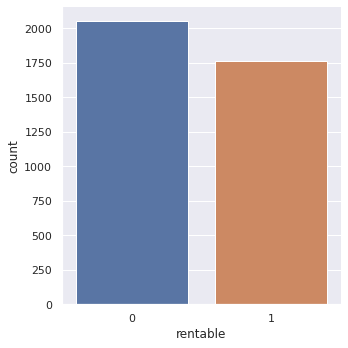

In [17]:
sns.set(style='darkgrid')

print(agroanalisis.groupby('rentable').size())
   
sns.catplot(x='rentable', data=agroanalisis, kind='count')

Como se puede comprobar, se encuentra bastante balanceado y no es necesario aplicar ninguna transformación.

##### 3.2.1 OneHot Encoding

En el *dataframe* existen datos de tipo categórico, los cuales pueden resultar problemáticos a la hora de aplicar el modelo de clasificación. Por ello, se ha decidido aplicar un **encoding** a este tipo de datos. Más concretamente, se ha decidido utilizar el **OneHot**, ya que otro tipo de encoding podría acarrear relaciones numéricas entre datos que realmente no poseen ningún tipo de orden.

Se aplicará a los campos *product* y *origen*.

In [18]:
# OneHot de product
df_OneHot = pd.get_dummies(agroanalisis[['product']])
agroanalisis = pd.concat([agroanalisis, df_OneHot], axis = 1)

In [19]:
# OneHot de origen
df_OneHot = pd.get_dummies(agroanalisis[['origen']])
agroanalisis = pd.concat([agroanalisis, df_OneHot], axis = 1)

In [20]:
# Descarte de columnas no numéricas
agroanalisis.drop(labels=['product', 'origen'], axis=1, inplace=True)
agroanalisis.head()

,YEAR,MONTH,temperatura,Precipitacion_group,Temperatura min req,Temperatura max req,Temperatura min opt,Temperatura max opt,distancia_mes_inicio_siem,distancia_mes_fin_siem,price_max_recolec,Volumen_max_recolec,MONTH_max_recolec,need_humidity_group,rentable,product_ACELGA,product_AJO,product_ALCACHOFA,product_APIO,product_BERENJENA,product_BROCOLI,product_CALABACIN,product_CALABAZA,product_CEBOLLA,product_CEBOLLETA,product_CHIRIVIA,product_COL BRUSELAS,product_COL CHINA,product_COL LOMBARDA,product_COL REPOLLO,product_COLIFLOR,product_ESCAROLA,product_ESPINACA,product_GUISANTE,product_HABA,product_JUDIA,product_LECHUGA,product_MAIZ,product_MELON,product_NABO,product_PATATA,product_PEPINO,product_PEREJIL,product_PIMIENTO,product_PUERRO,product_RABANITO,product_REMOLACHA,product_SANDIA,product_TOMATE,product_ZANAHORIA,origen_Andalucia,origen_Aragon,origen_Asturias,origen_Baleares,origen_Canarias,origen_Cantabria,origen_Castilla La Mancha,origen_Castilla Leon,origen_Cataluña,origen_Extremadura,origen_Galicia,origen_La Rioja,origen_Madrid,origen_Murcia,origen_Navarra,origen_Pais Vasco,origen_Valencia
5,2018,3,11.90,2.0,6.0,33.0,15.0,25.0,0.0,-2.0,1.035714,58905.0,6.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2018,4,14.84,1.0,6.0,33.0,15.0,25.0,1.0,-1.0,0.725000,16570.0,7.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,2018,5,17.50,0.0,6.0,33.0,15.0,25.0,2.0,0.0,0.529167,35470.0,8.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18,2018,10,18.05,1.0,6.0,33.0,15.0,25.0,1.0,-1.0,0.880000,61704.0,1.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20,2018,11,13.19,1.0,6.0,33.0,15.0,25.0,2.0,0.0,0.682381,106154.0,2.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
agroanalisis.shape

(3817, 67)

### 3.3 Aplicación de modelo de clasificación

Se usará el algoritmo **RandomForest**.  
Además, se utilizará **cross-validation**.  
En la división del dataset para datos de entrenamiento y test, se descartarán la columna objetivo *rentable*, así como *price_max_recolec* y *Volumen_max_recolec* puesto que a la hora de realizar la predicción no se dispondrá de estos valores a priori.

In [22]:
X = list(agroanalisis.columns)
X.remove('rentable')
X.remove('YEAR')
X.remove('price_max_recolec')
X.remove('Volumen_max_recolec')
X = agroanalisis[X]
y = agroanalisis['rentable']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=42)

In [23]:
cv = KFold(n_splits = 5, shuffle = True)

fold_accuracy = []
rndfor = ensemble.RandomForestClassifier(n_estimators=1000)
for train_fold, test_fold in cv.split(X_train):
  # División train test aleatoria
  fx_train = X_train.iloc[train_fold]
  fy_train = y_train.iloc[train_fold]
  fx_test = X_train.iloc[test_fold]
  fy_test = y_train.iloc[test_fold]
  # entrenamiento y ejecución del modelo
  rndfor.fit( X = fx_train, y = fy_train)
  fy_pred = rndfor.predict(X = fx_test)
  # evaluación del modelo
  acc = accuracy_score(fy_test, fy_pred)
  fold_accuracy.append(acc)
total_scores = sum(fold_accuracy)/len(fold_accuracy)

print(total_scores)


0.8917953026007212


In [24]:
# Fit y predicción
rndfor.fit( X = X_train, y = y_train)
y_pred = rndfor.predict(X = X_test)

print ("MAE:", metrics.mean_absolute_error(y_pred , y_test))
print ("MAPE:", metrics.mean_absolute_percentage_error(y_pred , y_test))
print ("MSE:", metrics.mean_squared_error(y_pred , y_test))
print ("R^2:", metrics.r2_score(y_pred , y_test))

MAE: 0.11518324607329843
MAPE: 231860713800051.78
MSE: 0.11518324607329843
R^2: 0.5375415769908042


#### 3.3.1 Matriz de confusión

Para una mejor visualización de los resultados de acierto y error en la predicción, se dibujará la matriz de confusión.

In [25]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[549  73]
 [ 59 465]]


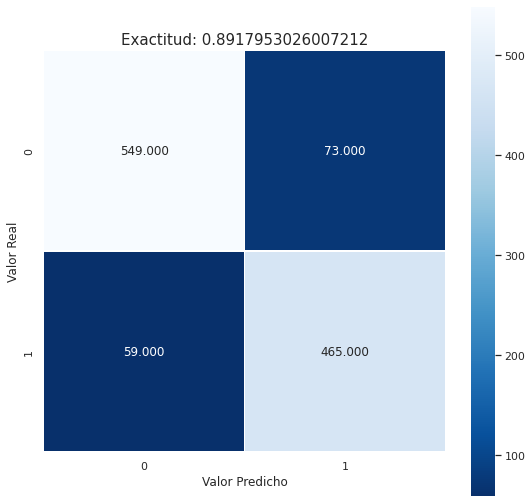

In [26]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Valor Real');
plt.xlabel('Valor Predicho');
all_sample_title = 'Exactitud: {0}'.format(total_scores)
plt.title(all_sample_title, size = 15);

Así, podríamos decir en principio que se trata de un modelo bastane preciso (89%) para determinar si la siembra de un cultivo es rentable o no.

### 3.4 Entrada del usuario

A continuación, haciendo uso de *sliders* de colab, se ha creado una pequeña interfaz para que el usuario pueda introducir los datos. Introduciendo el mes, la región, la precipitación y la temperatura, se mostrará un top 5 (si lo hay) de los cultivos que resulte más rentable sembrar.

In [27]:
with open('available_products.json', 'r') as available_products_file:
  available_products = json.load(available_products_file)

with open('product_origen_inference.json', 'r') as product_origen_inference_file:
  product_origen_inference = json.load(product_origen_inference_file)

In [28]:
product_data_columns = [
        "Temperatura min req",
        "Temperatura max req",
        "Temperatura min opt",
        "Temperatura max opt",
        "distancia_mes_inicio_siem",
        "distancia_mes_fin_siem",
        "MONTH_max_recolec",
        "need_humidity_group"
]

def predict_best_product(month, origen, temperatura, precipitacion):
  best_products = []

  for product in available_products:
      product_data = agroanalisis[(agroanalisis['product_'+product] == 1) & (agroanalisis['MONTH'] == month)]
      if len(product_data) <= 0:
        continue
      dict_features = {
        "MONTH": month,
        "temperatura": temperatura,
        "Precipitacion_group": precipitacion,
        **product_data[product_data_columns].iloc[0].to_dict(),
        **product_origen_inference
      }
      dict_features["product_"+product] = 1
      dict_features["origen_"+origen] = 1
      
      df_input = pd.DataFrame([dict_features])
      pred = rndfor.predict(df_input)[0]

      if pred == 1:
        best_products.append(product)

  return best_products

In [29]:
month = 7 #@param {type:"slider", min:1, max:12}
origen = "Madrid" #@param ["Andalucia", "Aragon", "Asturias", "Baleares", "Canarias", "Cantabria", "Castilla La Mancha", "Castilla Leon", "Cataluña", "Extremadura", "Galicia", "La Rioja", "Madrid", "Murcia", "Navarra", "Pais Vasco", "Valencia"]
temperature = 40 #@param {type:"slider", min:-20, max:47, step:0.01}
precipitacion_group = 1 #@param {type:"slider", min:0.0, max:2.0, step:1.0}

predict_best_product(month, origen, temperature, precipitacion_group)

['BROCOLI', 'COL BRUSELAS', 'COL CHINA', 'COLIFLOR', 'PEREJIL']

## 4. Línea de trabajo 3: Influencia de variables en el beneficio de un cultivo


Esta línea se abordará de dos maneras diferentes:
- Se podría realizar un **árbol de decisión de cada región**, y obtener así la importancia de cada característica dependiendo de dónde se haya sembrado el cultivo.
- Otra opción sería crear un **modelo para cada factor cuya influencia se quiera estudiar** (mes, temperatura y precipitación en este caso son los primordiales) que prediga el precio medio sin esa misma característica, y comparar con el precio real que introduzca el usuario. Así, si el precio medio sin ese factor es mucho más alto que el precio real, significará que esa característica ha afectado negativamente. Lo mismo sucede al contrario: si el precio medio predecido es mucho más bajo, ese factor afectó positivamente.

### 4.1 Influencia de variables por región

Dada una región,  se estudiará el grado en que los factores han contribuido. En este caso, se han construido modelos de árboles de decisión de ejemplo para tres regiones: Galicia, Castilla - La Mancha y Andalucía. Así se podrá comprobar cómo funciona esta estrategia con datos reales.

#### 4.1.1 Galicia

In [30]:
# Filtrar dataframe por la región elegida
aux = agroanalisis[agroanalisis['origen_Galicia'] == 1]
aux.head()

,YEAR,MONTH,temperatura,Precipitacion_group,Temperatura min req,Temperatura max req,Temperatura min opt,Temperatura max opt,distancia_mes_inicio_siem,distancia_mes_fin_siem,price_max_recolec,Volumen_max_recolec,MONTH_max_recolec,need_humidity_group,rentable,product_ACELGA,product_AJO,product_ALCACHOFA,product_APIO,product_BERENJENA,product_BROCOLI,product_CALABACIN,product_CALABAZA,product_CEBOLLA,product_CEBOLLETA,product_CHIRIVIA,product_COL BRUSELAS,product_COL CHINA,product_COL LOMBARDA,product_COL REPOLLO,product_COLIFLOR,product_ESCAROLA,product_ESPINACA,product_GUISANTE,product_HABA,product_JUDIA,product_LECHUGA,product_MAIZ,product_MELON,product_NABO,product_PATATA,product_PEPINO,product_PEREJIL,product_PIMIENTO,product_PUERRO,product_RABANITO,product_REMOLACHA,product_SANDIA,product_TOMATE,product_ZANAHORIA,origen_Andalucia,origen_Aragon,origen_Asturias,origen_Baleares,origen_Canarias,origen_Cantabria,origen_Castilla La Mancha,origen_Castilla Leon,origen_Cataluña,origen_Extremadura,origen_Galicia,origen_La Rioja,origen_Madrid,origen_Murcia,origen_Navarra,origen_Pais Vasco,origen_Valencia
287,2018,3,7.97,2.0,6.0,33.0,15.0,25.0,0.0,-2.0,0.600000,231.0,6.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
924,2018,9,20.32,0.0,7.0,30.0,14.0,24.0,0.0,-2.0,3.127511,119580.0,11.0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
926,2018,10,14.19,1.0,7.0,30.0,14.0,24.0,1.0,-1.0,2.988657,157130.0,1.0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
930,2019,11,10.07,2.0,7.0,30.0,14.0,24.0,2.0,0.0,3.081226,154920.0,3.0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1366,2018,3,7.97,2.0,7.0,29.0,15.0,18.0,0.0,-2.0,1.408372,53380.0,7.0,2.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


Se descartarán las características que no sirvan para el propósito: las de origen de las comunidades, los productos (ya que interesa saber qué factores tienen importancia en general en cada región, no algo dependiente del cultivo), el año, el precio, el volumen vendido y el mes de recolección. También se descartará el campo objetivo construido en el apartado anterior (*rentable*).

In [31]:
x_features = list(aux.columns)
x_features = [ item for item in x_features if 'origen_' not in item]
x_features = [ item for item in x_features if 'product_' not in item]
x_features.remove('rentable')
x_features.remove('YEAR')
x_features.remove('price_max_recolec')
x_features.remove('Volumen_max_recolec')
x_features.remove('MONTH_max_recolec')

Cabe destacar que no se hará división entre datos de train y test, sino que se empleará una estrategia de **train vs train**. Esto se debe a que los árboles que se van a obtener son **árboles descriptivos**, y se usarán para describir los datos, y no como modelo de predicción.

In [32]:
X = aux[x_features]
y = aux['price_max_recolec'] # Campo sobre el que se desea ver la influencia

In [33]:
regressor = DecisionTreeRegressor(criterion='mse', random_state=0)
regressor.fit(X, y)

y_pred = regressor.predict(X = X) # Predicción sobre los propios datos de train

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


In [34]:
print ('Feature Relevances')
pd.DataFrame({'Attributes': x_features ,
              'Decision Tree': regressor.feature_importances_})

Feature Relevances


,Attributes,Decision Tree
0,MONTH,0.076154
1,temperatura,0.078801
2,Precipitacion_group,0.016940
3,Temperatura min req,0.003789
4,Temperatura max req,0.359900
5,Temperatura min opt,0.138241
6,Temperatura max opt,0.146305
7,distancia_mes_inicio_siem,0.001435
8,distancia_mes_fin_siem,0.002983
9,need_humidity_group,0.175452


In [35]:
print ("MAE:", metrics.mean_absolute_error(y_pred , y))
print ("MAPE:", metrics.mean_absolute_percentage_error(y_pred , y))
print ("MSE:", metrics.mean_squared_error(y_pred , y))
print ("R^2:", metrics.r2_score(y_pred , y))

MAE: 0.0
MAPE: 0.0
MSE: 0.0
R^2: 1.0


Como se puede apreciar, el error de predicción es bajísimo, por lo que podemos concluir que los datos no tienen mucho ruido/distorsiones y el modelo describe correctamente el fenómeno.

#### 4.1.2 Castilla - La Mancha

In [36]:
# Filtrar dataframe por la región elegida
aux = agroanalisis[agroanalisis['origen_Castilla La Mancha'] == 1]
aux.head()

,YEAR,MONTH,temperatura,Precipitacion_group,Temperatura min req,Temperatura max req,Temperatura min opt,Temperatura max opt,distancia_mes_inicio_siem,distancia_mes_fin_siem,price_max_recolec,Volumen_max_recolec,MONTH_max_recolec,need_humidity_group,rentable,product_ACELGA,product_AJO,product_ALCACHOFA,product_APIO,product_BERENJENA,product_BROCOLI,product_CALABACIN,product_CALABAZA,product_CEBOLLA,product_CEBOLLETA,product_CHIRIVIA,product_COL BRUSELAS,product_COL CHINA,product_COL LOMBARDA,product_COL REPOLLO,product_COLIFLOR,product_ESCAROLA,product_ESPINACA,product_GUISANTE,product_HABA,product_JUDIA,product_LECHUGA,product_MAIZ,product_MELON,product_NABO,product_PATATA,product_PEPINO,product_PEREJIL,product_PIMIENTO,product_PUERRO,product_RABANITO,product_REMOLACHA,product_SANDIA,product_TOMATE,product_ZANAHORIA,origen_Andalucia,origen_Aragon,origen_Asturias,origen_Baleares,origen_Canarias,origen_Cantabria,origen_Castilla La Mancha,origen_Castilla Leon,origen_Cataluña,origen_Extremadura,origen_Galicia,origen_La Rioja,origen_Madrid,origen_Murcia,origen_Navarra,origen_Pais Vasco,origen_Valencia
87,2018,3,7.66,1.0,6.0,33.0,15.0,25.0,0.0,-2.0,1.120000,248740.0,6.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
89,2018,4,11.85,0.0,6.0,33.0,15.0,25.0,1.0,-1.0,0.776190,50195.0,7.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
91,2018,5,15.45,0.0,6.0,33.0,15.0,25.0,2.0,0.0,0.559091,134190.0,8.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
100,2018,10,14.23,0.0,6.0,33.0,15.0,25.0,1.0,-1.0,0.890476,113425.0,1.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
102,2018,11,9.23,0.0,6.0,33.0,15.0,25.0,2.0,0.0,0.707895,107030.0,2.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


Se descartarán las mismas características que en el apartado anterior.

In [37]:
x_features = list(aux.columns)
x_features = [ item for item in x_features if 'origen_' not in item]
x_features = [ item for item in x_features if 'product_' not in item]
x_features.remove('rentable')
x_features.remove('YEAR')
x_features.remove('price_max_recolec')
x_features.remove('Volumen_max_recolec')
x_features.remove('MONTH_max_recolec')

In [38]:
X = aux[x_features]
y = aux['price_max_recolec'] # Campo sobre el que se desea ver la influencia

In [39]:
regressor = DecisionTreeRegressor(criterion='mse', random_state=0)
regressor.fit(X, y)

y_pred = regressor.predict(X = X)

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


In [40]:
print ('Feature Relevances')
pd.DataFrame({'Attributes': x_features ,
              'Decision Tree': regressor.feature_importances_})

Feature Relevances


,Attributes,Decision Tree
0,MONTH,0.114665
1,temperatura,0.077658
2,Precipitacion_group,0.007806
3,Temperatura min req,0.426042
4,Temperatura max req,0.092111
5,Temperatura min opt,0.166185
6,Temperatura max opt,0.104534
7,distancia_mes_inicio_siem,0.006085
8,distancia_mes_fin_siem,0.001326
9,need_humidity_group,0.003588


In [41]:
print ("MAE:", metrics.mean_absolute_error(y_pred , y))
print ("MAPE:", metrics.mean_absolute_percentage_error(y_pred , y))
print ("MSE:", metrics.mean_squared_error(y_pred , y))
print ("R^2:", metrics.r2_score(y_pred , y))

MAE: 0.0
MAPE: 0.0
MSE: 0.0
R^2: 1.0


De nuevo el error es bajísimo, por lo que el modelo describe correctamente el fenómeno.

#### 4.1.3 Andalucía

In [42]:
aux = agroanalisis[agroanalisis['origen_Andalucia'] == 1]
aux.head()

,YEAR,MONTH,temperatura,Precipitacion_group,Temperatura min req,Temperatura max req,Temperatura min opt,Temperatura max opt,distancia_mes_inicio_siem,distancia_mes_fin_siem,price_max_recolec,Volumen_max_recolec,MONTH_max_recolec,need_humidity_group,rentable,product_ACELGA,product_AJO,product_ALCACHOFA,product_APIO,product_BERENJENA,product_BROCOLI,product_CALABACIN,product_CALABAZA,product_CEBOLLA,product_CEBOLLETA,product_CHIRIVIA,product_COL BRUSELAS,product_COL CHINA,product_COL LOMBARDA,product_COL REPOLLO,product_COLIFLOR,product_ESCAROLA,product_ESPINACA,product_GUISANTE,product_HABA,product_JUDIA,product_LECHUGA,product_MAIZ,product_MELON,product_NABO,product_PATATA,product_PEPINO,product_PEREJIL,product_PIMIENTO,product_PUERRO,product_RABANITO,product_REMOLACHA,product_SANDIA,product_TOMATE,product_ZANAHORIA,origen_Andalucia,origen_Aragon,origen_Asturias,origen_Baleares,origen_Canarias,origen_Cantabria,origen_Castilla La Mancha,origen_Castilla Leon,origen_Cataluña,origen_Extremadura,origen_Galicia,origen_La Rioja,origen_Madrid,origen_Murcia,origen_Navarra,origen_Pais Vasco,origen_Valencia
5,2018,3,11.90,2.0,6.0,33.0,15.0,25.0,0.0,-2.0,1.035714,58905.0,6.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2018,4,14.84,1.0,6.0,33.0,15.0,25.0,1.0,-1.0,0.725000,16570.0,7.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,2018,5,17.50,0.0,6.0,33.0,15.0,25.0,2.0,0.0,0.529167,35470.0,8.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18,2018,10,18.05,1.0,6.0,33.0,15.0,25.0,1.0,-1.0,0.880000,61704.0,1.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20,2018,11,13.19,1.0,6.0,33.0,15.0,25.0,2.0,0.0,0.682381,106154.0,2.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
x_features = list(aux.columns)
x_features = [ item for item in x_features if 'origen_' not in item]
x_features = [ item for item in x_features if 'product_' not in item]
x_features.remove('rentable')
x_features.remove('YEAR')
x_features.remove('price_max_recolec')
x_features.remove('Volumen_max_recolec')
x_features.remove('MONTH_max_recolec')

In [44]:
X = aux[x_features]
y = aux['price_max_recolec']

In [45]:
regressor = DecisionTreeRegressor(criterion='mse', random_state=0)
regressor.fit(X, y)

y_pred = regressor.predict(X = X)

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


In [46]:
print ('Feature Relevances')
pd.DataFrame({'Attributes': x_features ,
              'Decision Tree': regressor.feature_importances_})

Feature Relevances


,Attributes,Decision Tree
0,MONTH,0.022249
1,temperatura,0.131240
2,Precipitacion_group,0.002168
3,Temperatura min req,0.140059
4,Temperatura max req,0.222578
5,Temperatura min opt,0.341773
6,Temperatura max opt,0.101533
7,distancia_mes_inicio_siem,0.000848
8,distancia_mes_fin_siem,0.005457
9,need_humidity_group,0.032095


In [47]:
print ("MAE:", metrics.mean_absolute_error(y_pred , y))
print ("MAPE:", metrics.mean_absolute_percentage_error(y_pred , y))
print ("MSE:", metrics.mean_squared_error(y_pred , y))
print ("R^2:", metrics.r2_score(y_pred , y))

MAE: 0.0
MAPE: 0.0
MSE: 0.0
R^2: 1.0


De nuevo el error es bajísimo, por lo que el modelo describe correctamente el fenómeno.

#### 4.1.4 Conclusión

El contraste en la **importancia de cada región con respecto a la *need_humidity_group*** es destacable: en Galicia, al tratarse de la zona más húmeda, en los cultivos que se planten allí tiene sentido que se vean influenciados por la humedad más que en las otras dos regiones (0.17 de importancia en Galicia frente a 0.003 y 0.03 en CLM y Andalucía).  
Algo parecido ocurre con ***precipitacion_group***: en el caso de CLM y Andalucía, al tratarse de zonas en las que las precipitaciones son más intermitentes, tiene sentido que le el grupo de precipitación sea menos influyente en los cultivos que se siembren en estas regiones (0.007 en CLM y 0.002 en Andalucía).  
Respecto a la **temperatura de los cultivos**, en general tiene bastante importancia en todas las regiones en las que se han realizado pruebas. Destaca que la temperatura que más relevancia tiene en Galicia es la máxima. Si bien puede parecer inicialmente paradójico, debido a que el requerimiento de temperatura mínima es más estricto en Galicia, tiene sentido que el modelo le de más importancia. Esto es debido a que la diferencia de la temperatura real con la temperatura mínima del cultivo es menor que la diferencia con la temperatura máxima del cultivo. Esta lógica también se aplica a la temperatura mínima en las comunidades de Castilla-La Mancha y Andalucía.  

En general, las distancias hasta el mes de inicio y fin siembra no son demasiado influyentes.

### 4.2 Influencia de variables por característica 

Para estudiar la influencia de cada característica, se **predice el precio ignorando dicha característica** y se compara con el precio real. Por cada característica se crea un modelo.

In [48]:
x_features_all = ["MONTH",
"temperatura",
"Precipitacion_group",
*list(product_origen_inference.keys())]

x_features_month = [feature for feature in x_features_all if feature != 'MONTH']
x_features_temperatura = [feature for feature in x_features_all if feature != 'temperatura']
x_features_precipitacion = [feature for feature in x_features_all if feature != 'Precipitacion_group']

#### 4.2.1 Modelo del mes

In [49]:
X = agroanalisis[x_features_month]
y = agroanalisis['price_max_recolec']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)
X_train.head()

,temperatura,Precipitacion_group,product_ACELGA,product_AJO,product_ALCACHOFA,product_APIO,product_BERENJENA,product_BROCOLI,product_CALABACIN,product_CALABAZA,product_CEBOLLA,product_CEBOLLETA,product_CHIRIVIA,product_COL BRUSELAS,product_COL CHINA,product_COL LOMBARDA,product_COL REPOLLO,product_COLIFLOR,product_ESCAROLA,product_ESPINACA,product_GUISANTE,product_HABA,product_JUDIA,product_LECHUGA,product_MAIZ,product_MELON,product_NABO,product_PATATA,product_PEPINO,product_PEREJIL,product_PIMIENTO,product_PUERRO,product_RABANITO,product_REMOLACHA,product_SANDIA,product_TOMATE,product_ZANAHORIA,origen_Andalucia,origen_Aragon,origen_Asturias,origen_Baleares,origen_Canarias,origen_Cantabria,origen_Castilla La Mancha,origen_Castilla Leon,origen_Cataluña,origen_Extremadura,origen_Galicia,origen_La Rioja,origen_Madrid,origen_Murcia,origen_Navarra,origen_Pais Vasco,origen_Valencia
702,22.07,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
17623,9.40,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
10686,13.63,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
13470,9.51,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
10629,10.30,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [50]:
regr_month = RandomForestRegressor(n_estimators= 4, criterion='absolute_error', random_state=0)

# Entrenamiento y ejecución del modelo
regr_month.fit(X_train, y_train)
y_pred = regr_month.predict(X_test)

In [51]:
print ("MAE:", metrics.mean_absolute_error(y_pred , y_test))
print ("MAPE:", metrics.mean_absolute_percentage_error(y_pred , y_test))
print ("MSE:", metrics.mean_squared_error(y_pred , y_test))
print ("R^2:", metrics.r2_score(y_pred , y_test))

MAE: 0.2134568362975141
MAPE: 0.1806802168213629
MSE: 0.17175733461819367
R^2: 0.6936667696452574


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


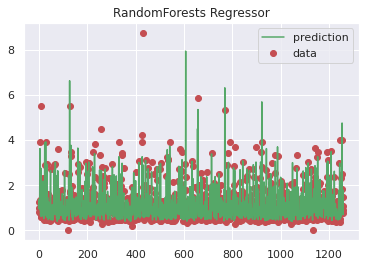

In [52]:
xx = np.stack(i for i in range(len(y_test)))
plt.scatter(xx, y_test, c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests Regressor")

plt.show()

#### 4.2.2 Modelo de la temperatura

In [53]:
X = agroanalisis[x_features_temperatura]
y = agroanalisis['price_max_recolec']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)
X_train.head()

,MONTH,Precipitacion_group,product_ACELGA,product_AJO,product_ALCACHOFA,product_APIO,product_BERENJENA,product_BROCOLI,product_CALABACIN,product_CALABAZA,product_CEBOLLA,product_CEBOLLETA,product_CHIRIVIA,product_COL BRUSELAS,product_COL CHINA,product_COL LOMBARDA,product_COL REPOLLO,product_COLIFLOR,product_ESCAROLA,product_ESPINACA,product_GUISANTE,product_HABA,product_JUDIA,product_LECHUGA,product_MAIZ,product_MELON,product_NABO,product_PATATA,product_PEPINO,product_PEREJIL,product_PIMIENTO,product_PUERRO,product_RABANITO,product_REMOLACHA,product_SANDIA,product_TOMATE,product_ZANAHORIA,origen_Andalucia,origen_Aragon,origen_Asturias,origen_Baleares,origen_Canarias,origen_Cantabria,origen_Castilla La Mancha,origen_Castilla Leon,origen_Cataluña,origen_Extremadura,origen_Galicia,origen_La Rioja,origen_Madrid,origen_Murcia,origen_Navarra,origen_Pais Vasco,origen_Valencia
702,9,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
17623,3,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
10686,10,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
13470,3,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
10629,4,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [54]:
regr_temp = RandomForestRegressor(n_estimators= 4, criterion='absolute_error', random_state=0)

# Entrenamiento y ejecución del modelo
regr_temp.fit(X_train, y_train)
y_pred = regr_temp.predict(X_test)

In [55]:
print ("MAE:", metrics.mean_absolute_error(y_pred , y_test))
print ("MAPE:", metrics.mean_absolute_percentage_error(y_pred , y_test))
print ("MSE:", metrics.mean_squared_error(y_pred , y_test))
print ("R^2:", metrics.r2_score(y_pred , y_test))

MAE: 0.21699185006444177
MAPE: 0.17694889125716265
MSE: 0.18760731484797083
R^2: 0.7073456286672091


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


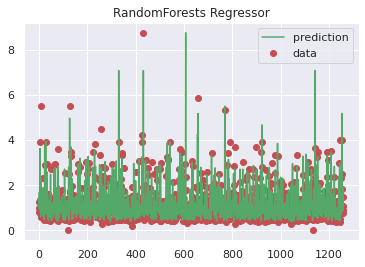

In [56]:
xx = np.stack(i for i in range(len(y_test)))
plt.scatter(xx, y_test, c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests Regressor")

plt.show()

#### 4.2.3 Modelo de la precipitación

In [57]:
X = agroanalisis[x_features_precipitacion]
y = agroanalisis['price_max_recolec']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)
X_train.head()

,MONTH,temperatura,product_ACELGA,product_AJO,product_ALCACHOFA,product_APIO,product_BERENJENA,product_BROCOLI,product_CALABACIN,product_CALABAZA,product_CEBOLLA,product_CEBOLLETA,product_CHIRIVIA,product_COL BRUSELAS,product_COL CHINA,product_COL LOMBARDA,product_COL REPOLLO,product_COLIFLOR,product_ESCAROLA,product_ESPINACA,product_GUISANTE,product_HABA,product_JUDIA,product_LECHUGA,product_MAIZ,product_MELON,product_NABO,product_PATATA,product_PEPINO,product_PEREJIL,product_PIMIENTO,product_PUERRO,product_RABANITO,product_REMOLACHA,product_SANDIA,product_TOMATE,product_ZANAHORIA,origen_Andalucia,origen_Aragon,origen_Asturias,origen_Baleares,origen_Canarias,origen_Cantabria,origen_Castilla La Mancha,origen_Castilla Leon,origen_Cataluña,origen_Extremadura,origen_Galicia,origen_La Rioja,origen_Madrid,origen_Murcia,origen_Navarra,origen_Pais Vasco,origen_Valencia
702,9,22.07,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
17623,3,9.40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
10686,10,13.63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
13470,3,9.51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
10629,4,10.30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [58]:
regr_precip = RandomForestRegressor(n_estimators= 4, criterion='absolute_error', random_state=0)

# Entrenamiento y ejecución del modelo
regr_precip.fit(X_train, y_train)
y_pred = regr_precip.predict(X_test)

In [59]:
print ("MAE:", metrics.mean_absolute_error(y_pred , y_test))
print ("MAPE:", metrics.mean_absolute_percentage_error(y_pred , y_test))
print ("MSE:", metrics.mean_squared_error(y_pred , y_test))
print ("R^2:", metrics.r2_score(y_pred , y_test))

MAE: 0.21748720457323692
MAPE: 0.18146379735391652
MSE: 0.17335876650329177
R^2: 0.7010750433823212


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


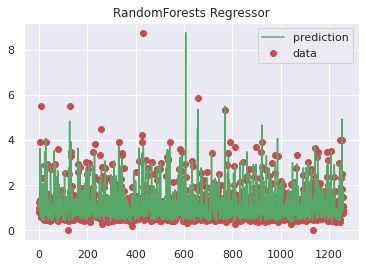

In [60]:
xx = np.stack(i for i in range(len(y_test)))
plt.scatter(xx, y_test, c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests Regressor")

plt.show()

#### 4.2.4 Integración de los modelos

A continuación, se integrarán todos los modelos anteriores, para mostrar la **diferencia entre los beneficios predichos y los reales**, indicando así si el factor influyó positiva o negativamente.

In [61]:
def to_table (dif_month, dif_temperatura, dif_precipitacion): # Funcion para mostrar las diferencias en forma de tabla
  print("Diferencia de beneficios")

  grid = widgets.Grid(4, 3, header_row=True, header_column=True)

  with grid.output_to(0, 0):
    print("Característica que falta")

  with grid.output_to(1, 0):
    print("Mes")
  with grid.output_to(2, 0):
    print("Temperatura")
  with grid.output_to(3, 0):
    print("Precipitación")

  with grid.output_to(1, 1):
    print(dif_month)
  with grid.output_to(2, 1):
    print(dif_temperatura)
  with grid.output_to(3, 1):
    print(dif_precipitacion)

  with grid.output_to(0, 1):
    print("Beneficio real - Beneficio esperado")

  with grid.output_to(0, 2):
    print('Influencia')
  with grid.output_to(1, 2):
    if dif_month < 0.2 and dif_month > -0.2:
      influence = 'neutral'
    else:
      influence = 'positive' if dif_month > 0 else 'negative'
    print(influence)
  with grid.output_to(2, 2):
    if dif_temperatura < 0.2 and dif_temperatura > -0.2:
      influence = 'neutral'
    else:
      influence = 'positive' if dif_temperatura > 0 else 'negative'
    print(influence)
  with grid.output_to(3, 2):
    if dif_precipitacion < 0.2 and dif_precipitacion > -0.2:
      influence = 'neutral'
    else:
      influence = 'positive' if dif_precipitacion > 0 else 'negative'
    print(influence)


In [62]:
def checkInfluence(month, temperatura, precipitacion_group, product, origen, price_max_recolec):
  dict_all_features = {
      "MONTH": month,
      "temperatura": temperatura,
      "Precipitacion_group": precipitacion_group,
      **product_origen_inference
  }
  dict_all_features["product_"+product] = 1
  dict_all_features["origen_"+origen] = 1
  dict_month = dict_all_features.copy()
  dict_temperatura = dict_all_features.copy()
  dict_precipitacion = dict_all_features.copy()

  dict_month.pop("MONTH", None)
  dict_temperatura.pop("temperatura", None)
  dict_precipitacion.pop("Precipitacion_group", None)
  
  df_month = pd.DataFrame([dict_month])
  df_temperatura = pd.DataFrame([dict_temperatura])
  df_precipitacion = pd.DataFrame([dict_precipitacion])

  pred_month = regr_month.predict(df_month)[0]
  pred_temperatura = regr_temp.predict(df_temperatura)[0]
  pred_precipitacion = regr_precip.predict(df_precipitacion)[0]
  
  dif_month = price_max_recolec - pred_month
  dif_temperatura = price_max_recolec - pred_temperatura
  dif_precipitacion = price_max_recolec - pred_precipitacion
  
  to_table(dif_month, dif_temperatura, dif_precipitacion)


#### 4.2.5 Ejemplos de prueba

A continuación se muestran ejemplos de inferencia sobre la tercera línea de trabajo.  

In [63]:
checkInfluence(3, 11.9, 2.0, "ACELGA", "Andalucia", 1.035714)
print('\n\n')
checkInfluence(12, 15.45, 0.0, "SANDIA", "Castilla La Mancha", 0.397377)

Diferencia de beneficios


,,
,,
,,
,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Característica que falta


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mes


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Temperatura


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Precipitación


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.40179270202500006


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.3655751111250001


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.5530949523333333


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Beneficio real - Beneficio esperado


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Influencia


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

positive


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

positive


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

positive


<IPython.core.display.Javascript object>




Diferencia de beneficios


,,
,,
,,
,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Característica que falta


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mes


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Temperatura


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Precipitación


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-0.1610256845131922


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-0.14062909092857145


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-0.1413482068810138


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Beneficio real - Beneficio esperado


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Influencia


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

neutral


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

neutral


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

neutral


<IPython.core.display.Javascript object>


Al realizar inferencia, se calcula la diferencia del precio por kilogramo obtenido y del precio esperado ignorando la característica analizada. Un valor positivo indica que el valor de dicha característica ha aportado positivamente al precio, mientras que un valor negativo refleja una influencia negativa. Los valores en el intervalo [-0.2, 0.2] se consideran neutrales puesto que se tratan de valores cercanos a 0.

In [64]:
checkInfluence(9, 16.9, 0.0, "BROCOLI", "Castilla La Mancha", 1.0)
checkInfluence(9, 5.9, 0.0, "BROCOLI", "Castilla La Mancha", 1.0)
print('\n\n')
checkInfluence(1, 20.9, 2.0, "SANDIA", "Castilla La Mancha", 1.0)
checkInfluence(1, 20.9, 0.0, "SANDIA", "Castilla La Mancha", 1.0)
print('\n\n')
checkInfluence(4, 20.9, 0.0, "ALCACHOFA", "Castilla La Mancha", 4.0)
checkInfluence(8, 20.9, 0.0, "ALCACHOFA", "Castilla La Mancha", 4.0)

Diferencia de beneficios


,,
,,
,,
,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Característica que falta


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mes


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Temperatura


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Precipitación


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-1.5943840579999997


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-0.17931547612499998


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-0.30629132176566887


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Beneficio real - Beneficio esperado


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Influencia


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

negative


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

neutral


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

negative


<IPython.core.display.Javascript object>

Diferencia de beneficios


,,
,,
,,
,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Característica que falta


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mes


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Temperatura


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Precipitación


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-0.5613636364999999


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-0.17931547612499998


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-0.38709197551566876


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Beneficio real - Beneficio esperado


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Influencia


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

negative


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

neutral


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

negative


<IPython.core.display.Javascript object>




Diferencia de beneficios


,,
,,
,,
,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Característica que falta


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mes


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Temperatura


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Precipitación


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.46291260008333335


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.516937296058874


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.4655493929943143


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Beneficio real - Beneficio esperado


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Influencia


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

positive


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

positive


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

positive


<IPython.core.display.Javascript object>

Diferencia de beneficios


,,
,,
,,
,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Característica que falta


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mes


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Temperatura


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Precipitación


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.4198351650833334


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.48377582793186336


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.4655493929943143


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Beneficio real - Beneficio esperado


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Influencia


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

positive


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

positive


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

positive


<IPython.core.display.Javascript object>




Diferencia de beneficios


,,
,,
,,
,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Característica que falta


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mes


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Temperatura


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Precipitación


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.25


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2.021875


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.25


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Beneficio real - Beneficio esperado


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Influencia


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

positive


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

positive


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

positive


<IPython.core.display.Javascript object>

Diferencia de beneficios


,,
,,
,,
,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Característica que falta


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mes


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Temperatura


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Precipitación


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.25


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1.3656249999999996


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.25


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Beneficio real - Beneficio esperado


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Influencia


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

positive


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

positive


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

positive


<IPython.core.display.Javascript object>

Como se puede observar, al cambiar una única característica no afecta a su propia influencia sino a la inflluencia de las otras 2 características. Esto es debido a que si en la realidad hubiese cambiado el valor de una característica, también habría cambiado el valor del precio por kilogramo obtenido en ese cultivo. Sin embarrgo, en nuestros ejemplos el precio por kilogramo permanece constante.

### 4.3 Entrada del usuario

A continuación, haciendo uso de *sliders* de colab, se ha creado una pequeña interfaz para que el usuario pueda introducir los datos. Introduciendo el mes, la región, la precipitación y la temperatura, se mostrará la influencia de los tres factores: a saber temperatura, mes y precipitación.

In [66]:
month = 7 #@param {type:"slider", min:1, max:12}
temperature = 37.13 #@param {type:"slider", min:-20, max:47, step:0.01}
precipitacion_group = 0 #@param {type:"slider", min:0.0, max:2.0, step:1.0}
product = "GUISANTE" #@param ["ACELGA", "AJO", "ALCACHOFA", "APIO", "BERENJENA", "BROCOLI", "CALABACIN", "CALABAZA", "CEBOLLA", "CEBOLLETA", "CHIRIVIA", "COL BRUSELAS", "COL CHINA", "COL LOMBARDA", "COL REPOLLO", "COLIFLOR", "ESCAROLA", "ESPINACA", "GUISANTE", "HABA", "JUDIA", "LECHUGA", "MAIZ", "MELON", "NABO", "PATATA", "PEPINO", "PEREJIL", "PIMIENTO", "PUERRO", "RABANITO", "REMOLACHA", "SANDIA", "TOMATE", "ZANAHORIA"]
origen = "Castilla La Mancha" #@param ["Andalucia", "Aragon", "Asturias", "Baleares", "Canarias", "Cantabria", "Castilla La Mancha", "Castilla Leon", "Cataluña", "Extremadura", "Galicia", "La Rioja", "Madrid", "Murcia", "Navarra", "Pais Vasco", "Valencia"]
price_max_recolec = 2.37 #@param {type:"slider", min:0.0, max:10.0, step:0.01}

checkInfluence(month, temperature, float(precipitacion_group), product, origen, price_max_recolec)

Diferencia de beneficios


,,
,,
,,
,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Característica que falta


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mes


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Temperatura


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Precipitación


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.06647937708333362


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.0979271885416666


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-0.011645622916666376


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Beneficio real - Beneficio esperado


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Influencia


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

neutral


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

neutral


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

neutral


<IPython.core.display.Javascript object>